# Librairies

In [1]:
import pandas as pd
import requests
from tqdm import tqdm
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pylab as plt

# Referential

In [2]:
# We combine false and true
df = pd.concat([
    pd.DataFrame(pd.read_json('raw/registration_points_operational_true.json').data.values[0]),
    pd.DataFrame(pd.read_json('raw/registration_points_operational_false.json').data.values[0])
]).reset_index()

In [3]:
df.id.duplicated().sum()

0

In [4]:
# Create geodataframe from coordinates
df = gpd.GeoDataFrame(
    df, 
    geometry = df.location.apply(lambda x : Point(list(x['coordinates']['latLon'].values())[::-1])),
    crs = 'epsg:4326'
)

<Axes: >

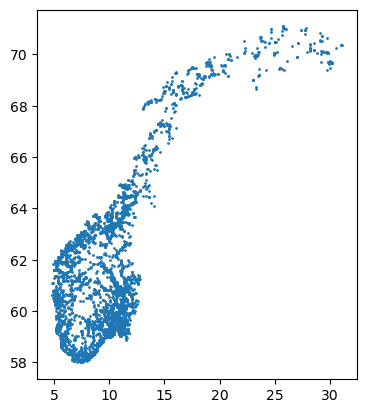

In [5]:
df.plot(markersize = 1)

In [6]:
print(df.shape)
print(2297+2716+78+1887+355+327+2+130)

(8436, 5)
7792


## Clip the data to Oslo

In [7]:
# Load the functional urban area

fua = gpd.read_file('../assets/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')

In [11]:
mask = fua.to_crs('EPSG:4326').loc[fua.eFUA_name == 'Oslo'].geometry.values[0]

In [7]:
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.ops import transform

def geodesic_point_buffer(lat, lon, m):
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(
        f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(m).simplify(1)  # distance in metres
    # return the simplified geometry bounding polygon
    return transform(tfmr.transform, buf)

(9.842376708984373, 11.951920145051217, 59.175992394066185, 60.587641761058286)

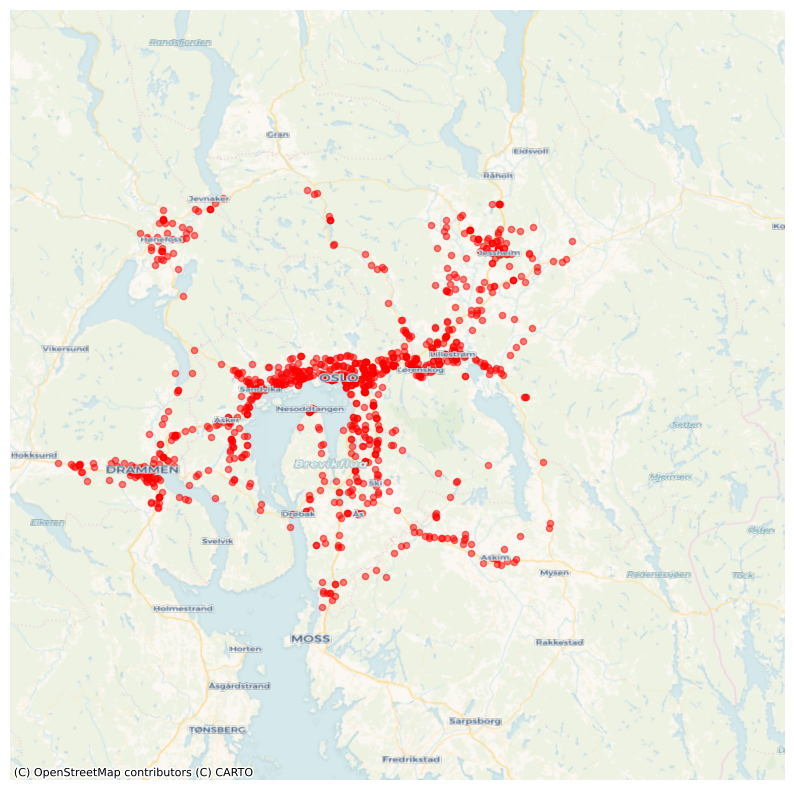

In [13]:
# Clip to Oslo 
city = 'Oslo'
city_center = (59.90614908926718,10.7686266680462) # lat, lon


import contextily as cx
#mask = geodesic_point_buffer(*city_center, 10000)

# Plot sensors
ax = df.clip(mask).plot(color = 'r', markersize = 20, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

In [14]:
# This should be done with gdf prior to join
gdf = df.clip(mask)

# Map matching with OSM

In [15]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../assets").resolve()))

from map_matching_OSM import points_matching

In [16]:
gdf = points_matching(gdf)

City downloaded


 18%|█▊        | 177/1008 [00:09<00:47, 17.61it/s]

Value Error - No roads found nearby current index


 18%|█▊        | 181/1008 [00:09<00:50, 16.30it/s]

Value Error - No roads found nearby current index


 27%|██▋       | 276/1008 [00:14<00:45, 16.08it/s]

Value Error - No roads found nearby current index


 31%|███▏      | 315/1008 [00:16<00:39, 17.37it/s]

Value Error - No roads found nearby current index


 32%|███▏      | 324/1008 [00:17<00:45, 14.90it/s]

Value Error - No roads found nearby current index


 33%|███▎      | 328/1008 [00:17<00:52, 12.86it/s]

Value Error - No roads found nearby current index


 36%|███▌      | 364/1008 [00:20<01:11,  8.95it/s]

Value Error - No roads found nearby current index


 37%|███▋      | 369/1008 [00:21<00:58, 10.98it/s]

Value Error - No roads found nearby current index


 37%|███▋      | 376/1008 [00:21<00:50, 12.43it/s]

Value Error - No roads found nearby current index


 38%|███▊      | 381/1008 [00:22<00:52, 12.02it/s]

Value Error - No roads found nearby current index


 60%|██████    | 608/1008 [00:32<00:08, 49.20it/s]

Value Error - No roads found nearby current index


 63%|██████▎   | 633/1008 [00:32<00:10, 36.98it/s]

Value Error - No roads found nearby current index


100%|██████████| 1008/1008 [00:40<00:00, 25.03it/s]

We failed to match 12 sensors
...on a total of 1008 sensors


In [17]:
gdf[['name', 'osm_name']].dropna().drop_duplicates()[:20]

,name,osm_name
4722,Gramsborgveien,Gramsborgveien
5432,Hagatjern,Hagatjernveien
5311,Stubberudv ved Asken,Stubberudveien
5641,Gamle Sørlandske nær Kornv,Gamle Sørlandske
6327,Skoger,Gamle Sørlandske
5374,Eikely,Unelsrudlina
5291,Gunnarsrud,Gundesølina
4541,Skoger skole,Gundesølina
4533,Moheim,Gundesølina
6718,Låland,Nordbyveien


# Query data

In [18]:
df.clip(mask).id.values.size

1008

In [20]:
url = 'https://trafikkdata-api.atlas.vegvesen.no/'
list_data = []
# Define the registration point ID
# pointid = "73840V2041694"
# These are the Registration point within the city area
for pointid in tqdm(df.clip(mask).id.values) :
  
  # Define the GraphQL query with string formatting
  query = f"""
  query {{
    trafficData(trafficRegistrationPointId: "{pointid}") {{
      volume {{
        average {{
          daily {{
            byYear {{
              year
              total {{
                volume {{
                  average
                }}
              }}
            }}
          }}
        }}
      }}
    }}
  }}
  """

  # Request the values
  response = requests.post(url=url, json={"query": query}) 
  # Extract and format the values
  sub = pd.DataFrame(response.json()['data']['trafficData']['volume']['average']['daily']['byYear'])
  sub['id'] = pointid
  list_data.append(sub)
  
data = pd.concat(list_data)
list_data = None
data.dropna(inplace=True)
data['AADT'] = data.total.apply(lambda x : x['volume']['average'])

# Save requested data
data[['year', 'id', 'AADT']].to_csv(f'{city}/raw/trafikkdata.csv', index = False)

  0%|          | 0/1008 [00:00<?, ?it/s]

100%|██████████| 1008/1008 [05:38<00:00,  2.98it/s]


In [21]:
data = pd.read_csv(f'{city}/raw/trafikkdata.csv')
data

,year,id,AADT
0,2021.0,98655V181055,5543
1,2022.0,61358V181333,1138
2,2022.0,22240V181333,2307
3,2022.0,87748V181044,2665
4,2024.0,87748V181044,2545
...,...,...,...
7589,2007.0,68131V1060159,2733
7590,2011.0,68131V1060159,2819
7591,2015.0,68131V1060159,3066
7592,2023.0,87567V444229,10997


In [22]:
jf = data.set_index('id').join(
    gdf.set_index('id')[['geometry', 'name', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid',]], how = 'inner'
)

In [23]:
jf.rename(columns = {'name':'raw_name'}, inplace=True)

In [24]:
jf.year.value_counts().sort_index()

year
1985.0     12
1986.0     20
1987.0     25
1988.0     19
1989.0     61
1990.0     40
1991.0     79
1992.0     60
1993.0     92
1994.0    114
1995.0    115
1996.0    120
1997.0    126
1998.0    115
1999.0    115
2000.0    115
2001.0    116
2002.0    143
2003.0    131
2004.0    164
2005.0    170
2006.0    188
2007.0    177
2008.0    175
2009.0    185
2010.0    194
2011.0    163
2012.0    144
2013.0    157
2014.0    141
2015.0    164
2016.0    254
2017.0    311
2018.0    347
2019.0    424
2020.0    473
2021.0    522
2022.0    515
2023.0    552
2024.0    556
Name: count, dtype: int64

In [25]:
jf = gpd.GeoDataFrame(jf, geometry = 'geometry', crs = 'epsg:4326')

In [27]:
from validate_dataset import validate_dataset

jf = validate_dataset(jf)

Number of NaN values for AADT: 0
Number of NaN values for geometry: 0
Number of low outliers for AADT: 0
Number of high outliers for AADT: 0


# Final saving

In [28]:
for year in range(2015, 2025) :
    jf[jf.year == year][[
        'AADT', 'geometry', 'raw_name', 'osm_name', 'osm_type', 'osm_lanes',  'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid', 
        ]].to_file(
        f'{city}/treated/{city}_AADT_{year}.geojson', index = False
    )